In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5" #! specify gpu here
import cv2
from PIL import Image as PILImage
from rich import print as richprint
import json
import textwrap
from pathlib import Path
import datetime
from collections import Counter

from object_reid import ObjectReId
from vision_pipeline.helpers import Struct, scale_img, img_row
from vision_pipeline.knowledge_tree.knowledge_tree import KnowledgeTree
from vision_pipeline.llm_data_generator.labelme_importer import LabelMeImporter

from context_action_framework.types import Detection, Label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
labelme_importer = LabelMeImporter()

config:
{
    'node_name': 'vision',
    'reid': False,
    'basler': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 180,
        'topic': 'basler',
        'camera_node': '/basler',
        'image_topic': 'image_rect_color',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_graph_img': True,
        'has_depth': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'table_name': 'table_vision',
        'parent_frame': 'vision_table_zero',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'work_surface_ignore_border_width': 50,
        'show_work_surface_detection': False,
        'use_worksurface_detection': True,
        'debug_work_surface_detection': False
    },
    'realsense': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 0,
        'topic': 'realsense',
        'camera_node': '/realsense',
        'image_topic': 'color/image_raw',
        'info_topic': 'color/camera_info',
        'depth_topic': 'aligned_depth_to_color/image_raw',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_depth_img': True,
        'publish_cluster_img': True,
        'publish_graph_img': False,
        'has_depth': True,
        'compute_gaps': True,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'camera_height': 0.2,
        'parent_frame': 'panda_2/realsense',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'calibration_file': '~/vision_pipeline/realsense_calib/realsense_calib.yaml',
        'debug_clustering': False
    },
    'obj_detection': {
        'debug': True,
        'model': 'yolov8',
        'yolact_dataset_file': '~/vision_pipeline/data_limited/yolact/2023-07-18_firealarms_hcas/dataset.json',
        'yolact_score_threshold': 0.5,
        'yolov8_model_file': 
'~/vision_pipeline/data_limited/yolov8/output_2024-07-17_20000_incl_new_jsi_imgs_p2/epoch60.pt',
        'yolov8_score_threshold': 0.5,
        'superglue_templates': '~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped',
        'superglue_model_file': 
'~/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt',
        'superglue_match_threshold': 0.5,
        'rotation_median_filter': False,
        'superglue_visualise_to_file': False,
        'classifier_model_file': 
'~/vision_pipeline/data_limited/classifier/2024-07-19__14-32_classify/lightning_logs/version_0/checkpoints/epoch=33
9-step=339.ckpt',
        'classifier_threshold': 0.2
    }
}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.learning_rate 1e-05

model.batch_size 64

model.freeze_backbone False

curr_weights_path 
/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt

Loaded SuperPoint model
Loaded SuperGlue model ("/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt" weights)


100%|██████████| 61/61 [00:00<00:00, 167.35it/s]


Loaded superglue templates 61

In [7]:
kt = KnowledgeTree()
kt.load_knowledge_tree()
kt.print_knowledge_tree()

kt.load_CLIP()

kg_nodes_path /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes

found camera info: /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/kalo/4_camera_info.pickle

device
├── hca
│   ├── kalo
│   │   ├── kalo_1
│   │   ├── kalo_2
│   │   ├── kalo_3
│   │   ├── kalo_4
│   │   ├── kalo_5
│   │   ├── kalo_6
│   │   ├── kalo_crop_back
│   │   └── kalo_crop_front
│   └── qundis
│       ├── qundis_1
│       ├── qundis_2
│       ├── qundis_3
│       ├── qundis_4
│       ├── qundis_5
│       ├── qundis_5_1
│       ├── qundis_5_2
│       ├── qundis_6
│       ├── qundis_6_1
│       ├── qundis_crop_back
│       └── qundis_crop_front
└── smoke_detector
    ├── fumonic
    │   ├── fumonic_1
    │   ├── fumonic_2
    │   ├── fumonic_3
    │   ├── fumonic_4
    │   ├── fumonic_crop_back
    │   └── fumonic_crop_front
    ├── hekatron
    │   ├── hekatron_1
    │   ├── hekatron_2
    │   ├── hekatron_3
    │   ├── hekatron_4
    │   ├── hekatron_5
    │   ├── hekatron_6
    │   ├── hekatron_crop_back
    │   └── hekatron_crop_front
    └── kaloremotus

self.device cuda

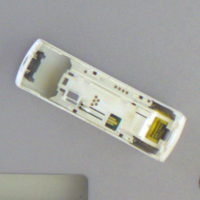

imgs_encoding.shape
torch.Size([25, 512])

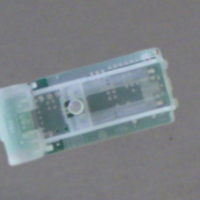

qundis_5 /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/qundis/5_qa.json


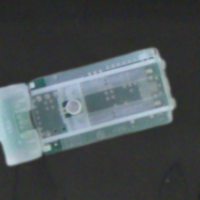

qundis_5_2 /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/qundis/5_2_qa.json


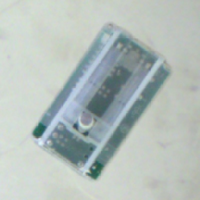

qundis_6_1 /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/qundis/6_1_qa.json


In [4]:
#! EXAMPLE:

# query_img_crop_img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped/firealarm_back_10/00_template_0068.jpg")
query_img_crop_img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped/hca_back_03/0006.jpg")

query_crop_img = PILImage.open(query_img_crop_img_path)

# display(Image.fromarray(scale_img(cv2.cvtColor(query_crop_img, cv2.COLOR_BGR2RGB))))
display(query_crop_img.resize((200, 200)))

topk_keys = kt.get_nearest_neighbour(query_crop_img, k=3)

for topk_key in topk_keys:

    device_data = kt.devices_data[topk_key]
    display(device_data.crop_img.resize((200, 200)))

    topk_i = kt.devices_data[topk_key]
    # print("top:", topk_key, topk_i)

    print(topk_key, device_data.qa_json_path)


In [13]:
objective = textwrap.dedent("""You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.""")

available_tools = textwrap.dedent("""
Available actions:
turn: if the front of the device is showing, the device can be turned to show the back.
move: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces, either using the cutter or the CNC mill.
unscrew: unscrew a screw from a device.
push: can be used to push out a plastic_clip from a device.

Background information:
If the module is vision you can perform the 'move' action.
If the module is vise you can perform the actions 'lever', 'move', 'push', and 'cut'. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. \n""")

def get_example_texts(topk_keys, k=3, only_bad_examples=False, gt_action=""):


    if only_bad_examples:
        _topk_keys = []
        for idx, topk_key in enumerate(topk_keys):
            device_data = kt.devices_data[topk_key]
            QAs = device_data.qa_json_data
            action = None
            for qa in QAs:
                if isinstance(qa['A'], dict):
                    for key, value in qa['A'].items():
                        if key == 'action':
                            action = value
                            break
            # only add examples that aren't correct
            if action != gt_action:
                _topk_keys.append(topk_key)

        if len(_topk_keys) > k:
            _topk_keys = _topk_keys[:k]

    else:
        _topk_keys = topk_keys[:k]

    # now get the example texts
    examples_text = ""
    for idx, topk_key in enumerate(_topk_keys):
        device_data = kt.devices_data[topk_key]
        QAs = device_data.qa_json_data
        
        # print(QAs)
        examples_text += f"Example {idx+1}:\n"
        
        for qa in QAs:
            examples_text += f"Q: {qa['Q']}\n"
            if isinstance(qa['A'], dict):
                # print("DICT!")
                examples_text += "A: {\n"
                for key, value in qa['A'].items():
                    examples_text += f"{key}: {value}\n"
                examples_text += "}\n"
            else:
                examples_text += f"A: {qa['A']}\n"
        
        examples_text += "\n"

    return examples_text

def get_basic_majority_vote(topk_keys):
    def most_common(lst):
        data = Counter(lst)
        return data.most_common(1)[0][0]

    votes = []
    for idx, topk_key in enumerate(topk_keys):
        device_data = kt.devices_data[topk_key]
        QAs = device_data.qa_json_data
        for qa in QAs:
            if isinstance(qa['A'], dict):
                for key, value in qa['A'].items():
                    if key == 'action':
                        votes.append(value)

    return most_common(votes), votes
    # TODO: WIP


In [6]:
def get_query_text(detections, graph_relations, module=None):

    A_relations = graph_relations.to_text()

    
    # include the module name in the relations
    if module is not None:
        richprint("module", module.name)
        A_relations = f"at_location(table_{module.name}). " + A_relations
    else:
        richprint("[red]Missing module name!")
    
    positions_list = []
    for detection in detections:
        text = f"{detection.label.name}"
        if detection.label_face is not None:
            text += f" {detection.label_face.name}"
        
        # todo: better label names
        # if detection.label_precise is not None:
        #     label_id = detection.label_precise.split("_")[-1]
        #     text += f" (id: {label_id})"

        if detection.label_precise_name is not None:
            text += f" ({detection.label_precise_name})"
    
        text += f" at ({detection.center_px[0]}, {detection.center_px[1]})"
        positions_list.append(text)


    
    A_positions = ", ".join(positions_list) + "."

    # print("A_positions:", A_positions)

    query_text = '''End of examples. You are given these facts about a query:\n'''
    
    
    # query_text += "Q: Where is the device?\n"
    # query_text += f"A: \n\n"

    query_text += "Q: What are the object relations?\n"
    query_text += f"A: {A_relations}\n\n"

    query_text += "Q: What are the object positions?\n"
    query_text += f"A: {A_positions}\n"

    query_text += textwrap.dedent("""
    Q: What is the JSON formatted disassembly step? Use the format:
    {
    reasoning: [explain you reasoning for tool choice],
    tool: [tool name],
    tool_arguments: [arguments to tool function],\n""")
    if module is not None:
        query_text += f"current_module: {module.name},\n"
    query_text += textwrap.dedent("""new_module: [the new module the device is on after performing the action]\n}""")
    # print(query_text)
    return query_text

making folder /home/docker/vision_pipeline/saves/2024-09-06_10:06:57_knowledge_tree_hca_08_(exim)_bad_examples


resetting worksurface detection

Converting 1:   0%|          | 0/5 [00:00<?, ?it/s]

filename 1.json

running worksurface detection...

camera: basler

classify: exim, 08, conf: 0.72

elapsed_time_classify_and_rot 0.02440878306515515

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)/1.jpg
len(batch_crop_imgs) 1


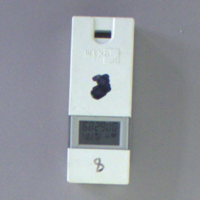

imgs_encoding.shape
torch.Size([25, 512])

basic_majority_vote move

Camera.basler
Module.vision
Camera.basler
Module.vision
Camera.basler
Module.vision


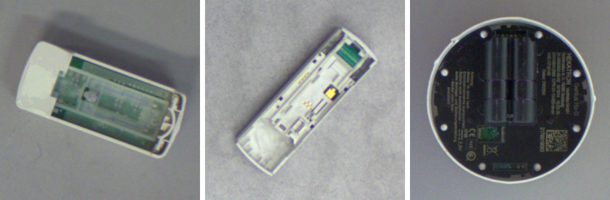

module vision

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.

Available actions:
turn: if the front of the device is showing, the device can be turned to show the back.
move: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces, either using the cutter or the CNC mill.
unscrew: unscrew a screw from a device.
push: can be used to push out a plastic_clip from a device.

Background information:
If the module is vision you can perform the 'move' action.
If the module is vise you can perform the actions 'lever', 'move', 'push', and 'cut'. Lever can only be used when the device is on the 

resetting worksurface detection

Converting 2:  20%|██        | 1/5 [00:00<00:01,  3.52it/s]

filename 2.json

running worksurface detection...

camera: basler

classify: exim, 08, conf: 1.00

elapsed_time_classify_and_rot 0.02645794884301722

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)/2.jpg
len(batch_crop_imgs) 1


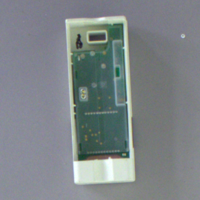

imgs_encoding.shape
torch.Size([25, 512])

basic_majority_vote move

Camera.basler
Module.vise
Camera.basler
Module.vise
Camera.basler
Module.vision


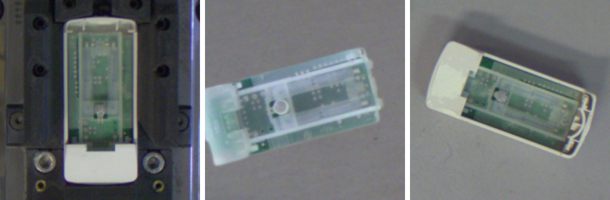

module vision

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.

Available actions:
turn: if the front of the device is showing, the device can be turned to show the back.
move: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces, either using the cutter or the CNC mill.
unscrew: unscrew a screw from a device.
push: can be used to push out a plastic_clip from a device.

Background information:
If the module is vision you can perform the 'move' action.
If the module is vise you can perform the actions 'lever', 'move', 'push', and 'cut'. Lever can only be used when the device is on the 

resetting worksurface detection

Converting 3:  40%|████      | 2/5 [00:00<00:00,  3.46it/s]

filename 3.json

found camera info: /home/docker/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)/3_camera_info.pickle

camera: realsense

classify: exim, 08, conf: 0.96

elapsed_time_classify_and_rot 0.019362922059372067

trying again with dilated mask!

 no depth info! gap

trying again with dilated mask!

 no depth info! hca

trying again with dilated mask!

 no depth info! pcb_covered

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


gaps None

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)/3.jpg
len(batch_crop_imgs) 1


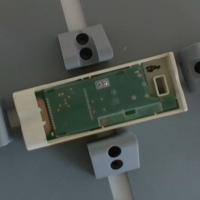

imgs_encoding.shape
torch.Size([25, 512])

basic_majority_vote cut

Camera.basler
Module.vise
Camera.basler
Module.vise
Camera.basler
Module.vise


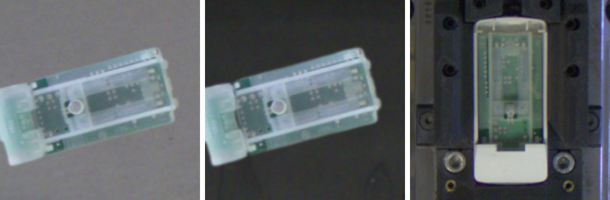

module vise

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.

Available actions:
turn: if the front of the device is showing, the device can be turned to show the back.
move: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces, either using the cutter or the CNC mill.
unscrew: unscrew a screw from a device.
push: can be used to push out a plastic_clip from a device.

Background information:
If the module is vision you can perform the 'move' action.
If the module is vise you can perform the actions 'lever', 'move', 'push', and 'cut'. Lever can only be used when the device is on the 

resetting worksurface detection

Converting 4:  60%|██████    | 3/5 [00:04<00:04,  2.10s/it]

filename 4.json

running worksurface detection...

camera: basler

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)/4.jpg
len(batch_crop_imgs) 1


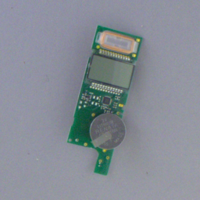

imgs_encoding.shape
torch.Size([25, 512])

basic_majority_vote move

Camera.basler
Module.vise
Camera.basler
Module.cutter
Camera.basler
Module.cutter


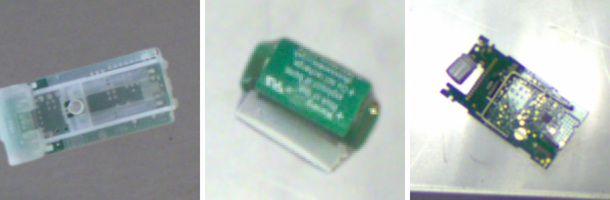

module vise

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.

Available actions:
turn: if the front of the device is showing, the device can be turned to show the back.
move: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces, either using the cutter or the CNC mill.
unscrew: unscrew a screw from a device.
push: can be used to push out a plastic_clip from a device.

Background information:
If the module is vision you can perform the 'move' action.
If the module is vise you can perform the actions 'lever', 'move', 'push', and 'cut'. Lever can only be used when the device is on the 

resetting worksurface detection

Converting 5:  80%|████████  | 4/5 [00:05<00:01,  1.40s/it]

filename 5.json

running worksurface detection...

camera: basler

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)/5.jpg
len(batch_crop_imgs) 1


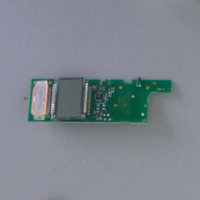

imgs_encoding.shape
torch.Size([25, 512])

basic_majority_vote cut

Camera.basler
Module.vise
Camera.basler
Module.cutter
Camera.basler
Module.cutter


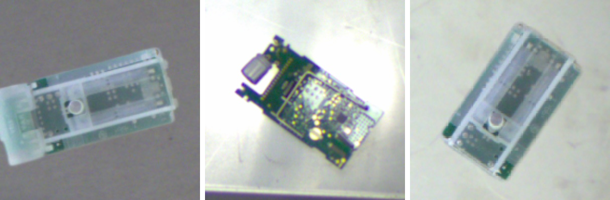

module cutter

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.

Available actions:
turn: if the front of the device is showing, the device can be turned to show the back.
move: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces, either using the cutter or the CNC mill.
unscrew: unscrew a screw from a device.
push: can be used to push out a plastic_clip from a device.

Background information:
If the module is vision you can perform the 'move' action.
If the module is vise you can perform the actions 'lever', 'move', 'push', and 'cut'. Lever can only be used when the device is on the 

resetting worksurface detection

Converting 5: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


In [24]:
only_bad_examples = True

# print("kt.devices_data", kt.devices_data)
# folder = Path("~/datasets2/reconcycle/knowledge_tree_tests/hca_01_(kalo2)").expanduser()
# folder = Path("~/datasets2/reconcycle/knowledge_tree_tests/hca_02_(minol)").expanduser()
# folder = Path("~/datasets2/reconcycle/knowledge_tree_tests/hca_05_(ecotron)").expanduser()
folder = Path("~/datasets2/reconcycle/knowledge_tree_tests/hca_08_(exim)").expanduser()

save_path = Path("~/vision_pipeline/saves/{date:%Y-%m-%d_%H:%M:%S}_knowledge_tree_{folder}".format(date=datetime.datetime.now(), folder=folder.name)).expanduser()

if only_bad_examples:
    save_path  = Path(str(save_path) + "_bad_examples")

# check if file path is empty
if not os.path.exists(save_path):
    print("making folder", save_path)
    os.makedirs(save_path)
    
if os.listdir(save_path):
    print("[red]directory not empty! exiting...[/red]")
    sys.exit()

gt_actions = []
majority_votes = []
for img_path, colour_img, detections, graph_relations, module, camera, batch_crop_imgs, gt_action in labelme_importer.process_labelme_dir(folder, use_yield=True):

    print("img_path", img_path)
    print("len(batch_crop_imgs)", len(batch_crop_imgs))

    # for detection in detections:
    #     print(detection.label, detection.label_face, detection.label_precise)

    if len(batch_crop_imgs) > 0:
        batch_crop_img = PILImage.fromarray(cv2.cvtColor(batch_crop_imgs[0], cv2.COLOR_BGR2RGB))


        batch_crop_img.save(save_path / f"{img_path.stem}_query.jpg")
        display(batch_crop_img.resize((200, 200)))

        topk_keys = kt.get_nearest_neighbour(batch_crop_img, k=5)

        # richprint("topk_keys", topk_keys)

        basic_majority_vote, votes = get_basic_majority_vote(topk_keys)
        gt_actions.append(gt_action)
        majority_votes.append(basic_majority_vote)
        
        richprint("basic_majority_vote", basic_majority_vote)
        # richprint(votes)

        for topk_key in topk_keys[:3]:
            device_data = kt.devices_data[topk_key]
            print(device_data.camera)
            print(device_data.module)

        # TODO: filter by module being the same as the module in the query image
        # TODO: filter by components. Eg. if query image contains plastic_clip, look for plastic_clip in knowledge tree

        imgs = [kt.devices_data[topk_key].crop_img for topk_key in topk_keys[:3]]
        row_of_imgs = img_row(imgs)

        row_of_imgs.save(save_path / f"{img_path.stem}_knowledge_tree_knn.jpg")
        display(row_of_imgs.resize((int(row_of_imgs.size[0] / 2), int(row_of_imgs.size[1] / 2))))
        
        example_texts = get_example_texts(topk_keys, k=3, only_bad_examples=only_bad_examples, gt_action=gt_action) # get top 3 example texts

        query_texts = get_query_text(detections, graph_relations, module)

        print(objective)
        print(available_tools)
        print(example_texts)
        print(query_texts)
       

        with open(save_path / f"{img_path.stem}.log", 'w') as f:
            f.write(f"img_path: {img_path}\n")
            f.write(f"topk_keys: {topk_keys}, num keys (k): {len(topk_keys)}\n")
            f.write(f"votes: {votes}\n")
            f.write(f"basic_majority_vote: {basic_majority_vote}\n")
            f.write(f"gt action: {gt_action}\n")

        with open(save_path / f"{img_path.stem}_llm_query.txt", 'w') as f:
            f.write(objective + "\n")
            f.write(available_tools + "\n")
            f.write(example_texts +"\n")
            f.write(query_texts + "\n")

        with open(save_path / f"{img_path.stem}_llm_response.txt", 'w') as f:
            f.write("")

    # break #! DEBUG
    count_correct_majority_votes = 0
    for gt_action, majority_vote in zip(gt_actions, majority_votes):
        if gt_action == majority_vote:
            count_correct_majority_votes += 1

    with open(save_path / "000_results.txt", 'w') as f:
        f.write(f"only_bad_examples: {only_bad_examples}\n")
        f.write(f"gt: {gt_actions}\n")
        f.write(f"majority_votes: {majority_votes}\n")
        f.write(f"accuracy majority vote: {count_correct_majority_votes} of {len(majority_votes)} correct\n")

    